# Plateforme Agnostique de Traitement et d'Analyse des Textes
### Carnet d'expérimentation
---

## Sujet : Expérience ObsInfo2307

---

# Imports

In [1]:
cd ../..

/Volumes/Geek/Work/Patat


In [2]:
import importlib
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
tqdm.pandas()

# Chargement Données

In [3]:
import patat.util.gsheet

gs = patat.util.gsheet.GoogleSheet()

sheet_id = '1bEXdqyD7so-xm54_k-FMZchVVIcO8HjPSY1mA-wGW-w'
range_name = 'Data'

df_obsinfo = gs.read_df(sheet_id,range_name)

In [4]:
labels = [
    'infox',
    'lieux, dates et personnes',
    'faits',
    'opinions',
    'subjectif',
    'propos rapporté',
    'sources citées',
    'fausse nouvelle',
    'insinuation',
    'exagération',
    'titre décalé',
]

In [5]:
import numpy as np

In [6]:
def normalize(x):
    if x == '0':
        return 0.0
    elif x== '1':
        return 1.0
    else:
        return np.NaN

In [7]:
for label in labels:
    df_obsinfo[label]=df_obsinfo[label].apply(normalize)

In [8]:
df_obsinfo['url_h'] = df_obsinfo['url_labelizer'].apply(lambda s: s[-40:])

In [9]:
df_obsinfo[labels].isna().sum()

infox                        6
lieux, dates et personnes    5
faits                        4
opinions                     4
subjectif                    5
propos rapporté              4
sources citées               6
fausse nouvelle              5
insinuation                  5
exagération                  6
titre décalé                 5
dtype: int64

### Constats
- Entre 4 et 6 cellules vides par label

# Moyennes et accords

In [10]:
df_mean = df_obsinfo.pivot_table(index='title',values=labels,aggfunc='mean')

In [11]:
df_accord = df_mean.apply(lambda x : abs(2*x-1))

## Sommes des Moyennes

In [12]:
mean_sum = pd.DataFrame(df_mean.sum(),columns=['mean']).sort_values('mean')
mean_sum

,mean
titre décalé,10.660714
fausse nouvelle,23.357143
propos rapporté,30.964286
infox,37.767857
exagération,45.000000
insinuation,45.446429
subjectif,60.375000
sources citées,71.446429
opinions,72.982143
"lieux, dates et personnes",94.107143


<Axes: >

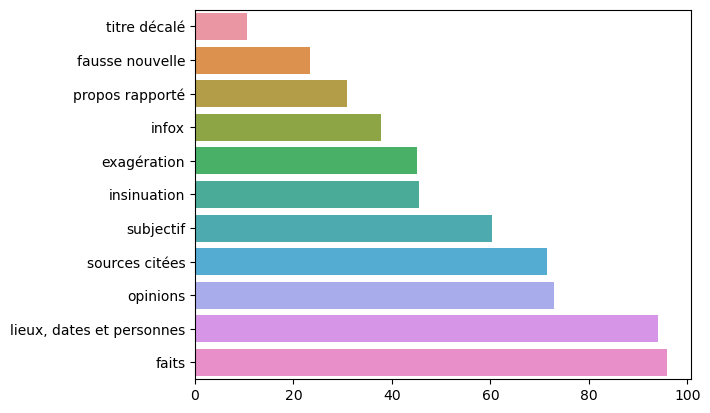

In [13]:
sns.barplot(mean_sum.T,orient="h")

### Constats
- titre décalé : 10% de 1
- fausse nouvelle : 23% de 1
- Lieux dates et personnes : 94% de 1
- faits : 95 %

## Sommes des Accords

In [14]:
accord_sum = pd.DataFrame(df_accord.sum(),columns=['sum']).sort_values('sum')
accord_sum

,sum
insinuation,50.750000
propos rapporté,55.285714
sources citées,59.392857
infox,62.892857
exagération,63.000000
opinions,66.750000
fausse nouvelle,68.071429
subjectif,71.535714
titre décalé,79.964286
"lieux, dates et personnes",88.214286


<Axes: >

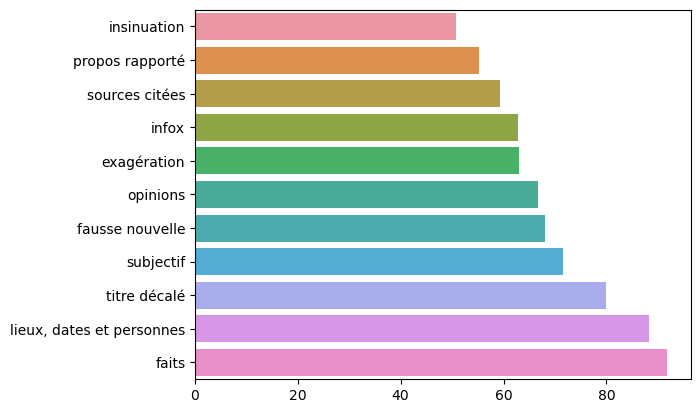

In [15]:
sns.barplot(accord_sum.T,orient="h")

## Comptage accords > seuil

In [38]:
threshold = 0.5

In [39]:
accord_count = pd.DataFrame(df_accord.apply(lambda x: x>=threshold).sum(),columns=['count']).sort_values('count')
accord_count

,count
insinuation,59
sources citées,68
infox,72
propos rapporté,72
exagération,73
opinions,78
fausse nouvelle,79
subjectif,79
titre décalé,90
"lieux, dates et personnes",96


<Axes: >

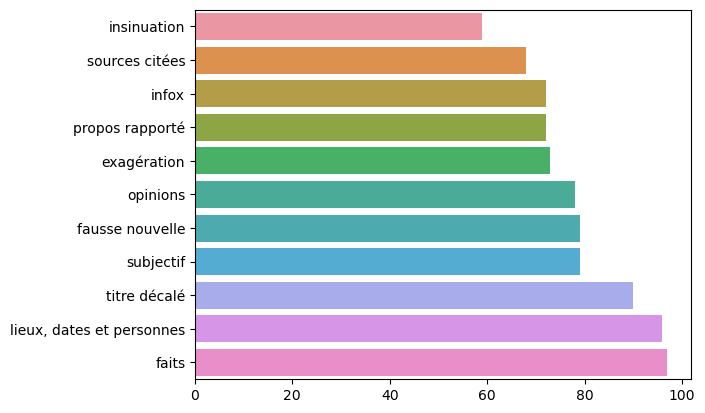

In [18]:
sns.barplot(accord_count.T,orient="h")

## Polarité des accords

In [40]:
df_accord_filter = df_accord.apply(lambda x: x>=threshold)

In [41]:
polarities_data = {}
for index,row in df_accord_filter.iterrows():
    for col in row.keys():
        if row[col]:
            data = polarities_data.get(col,[])
            data.append(df_mean.loc[index,col])
            polarities_data[col]=data

In [42]:
polarities = []
for label in polarities_data.keys():
    polarities.append({
        'label': label,
        'acc_count': len(polarities_data[label]),
        'acc_sum': sum(polarities_data[label]),
        'total_mean': mean_sum.loc[label]['mean']/100,
    })
df_polarities = pd.DataFrame(polarities)
df_polarities['polarity']=df_polarities['acc_sum']/df_polarities['acc_count']
df_polarities['pol_bias']=df_polarities['polarity']-df_polarities['total_mean']
df_polarities

,label,acc_count,acc_sum,total_mean,polarity,pol_bias
0,exagération,73,30.732143,0.450000,0.420988,-0.029012
1,faits,97,94.214286,0.959286,0.971281,0.011996
2,fausse nouvelle,79,13.267857,0.233571,0.167948,-0.065624
3,infox,72,24.107143,0.377679,0.334821,-0.042857
4,"lieux, dates et personnes",96,91.732143,0.941071,0.955543,0.014472
5,opinions,78,62.107143,0.729821,0.796245,0.066424
6,sources citées,68,54.464286,0.714464,0.800945,0.086481
7,subjectif,79,49.767857,0.603750,0.629973,0.026223
8,titre décalé,90,6.017857,0.106607,0.066865,-0.039742
9,insinuation,59,23.500000,0.454464,0.398305,-0.056159


<Axes: xlabel='pol_bias', ylabel='label'>

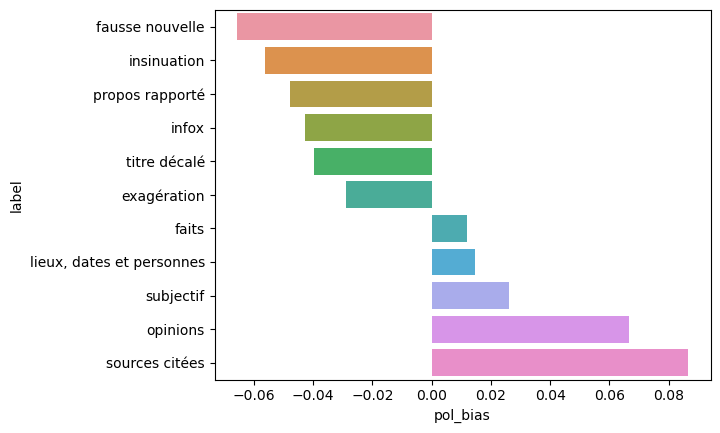

In [43]:
sns.barplot(df_polarities.sort_values('pol_bias'),y='label',x='pol_bias',)

### Constats
- Biais de polarité compris entre -0.14 et +0.17 
- Corrélation entre somme des moyennes et polarité des accords

### A calculer : Nombre d'accord par valeur 0/1, à comparer avec nombre moyen

# Comparaisons observateurs

In [44]:
df_obs = df_obsinfo.pivot_table(index='observateur',aggfunc='sum')[labels]

In [45]:
df_obs = df_obs.reset_index()

In [46]:
df_obs

,observateur,infox,"lieux, dates et personnes",faits,opinions,subjectif,propos rapporté,sources citées,fausse nouvelle,insinuation,exagération,titre décalé
0,BI,29.0,94.0,99.0,93.0,74.0,21.0,82.0,9.0,24.0,44.0,21.0
1,FB,20.0,88.0,91.0,78.0,69.0,14.0,73.0,8.0,21.0,36.0,3.0
2,FM,33.0,73.0,92.0,72.0,60.0,22.0,57.0,10.0,41.0,34.0,4.0
3,GA,34.0,100.0,100.0,87.0,52.0,22.0,87.0,32.0,54.0,42.0,16.0
4,GG,47.0,93.0,96.0,66.0,67.0,76.0,76.0,22.0,73.0,53.0,17.0
5,LL,29.0,100.0,91.0,45.0,47.0,66.0,78.0,24.0,43.0,35.0,1.0
6,MC,44.0,100.0,99.0,66.0,48.0,11.0,46.0,34.0,59.0,52.0,8.0
7,PE,64.0,100.0,96.0,74.0,63.0,14.0,68.0,46.0,46.0,61.0,14.0


<Axes: xlabel='observateur', ylabel='infox'>

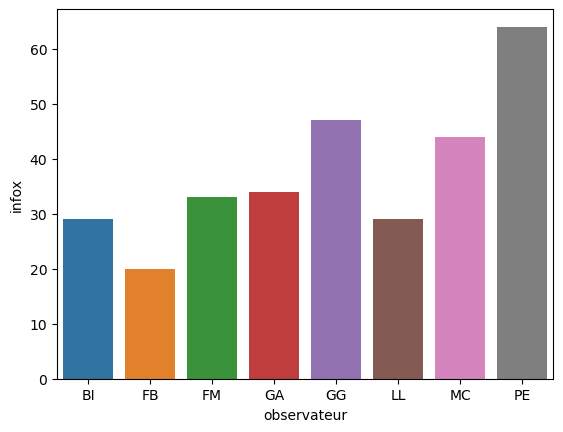

In [48]:
sns.barplot(df_obs,x='observateur',y='infox')

<Axes: xlabel='observateur', ylabel='opinions'>

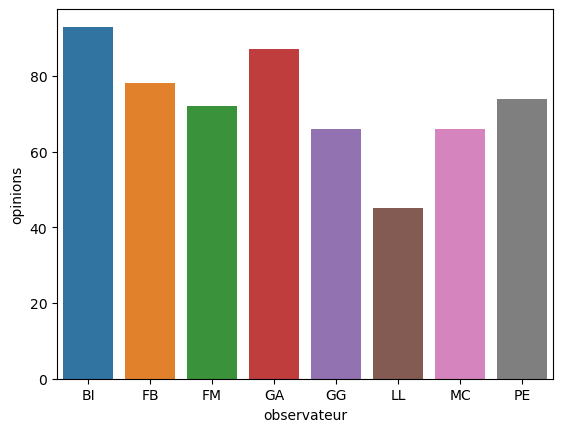

In [50]:
sns.barplot(df_obs,x='observateur',y='opinions')

## Ecarts par label

In [51]:
df_std = pd.DataFrame(df_obs[labels].std(),columns=['std']).sort_values('std')
df_std

,std
faits,3.741657
titre décalé,7.464200
"lieux, dates et personnes",9.411239
exagération,9.855202
subjectif,10.085350
sources citées,13.548194
infox,13.721724
fausse nouvelle,13.747078
opinions,14.657397
insinuation,17.315868


<Axes: >

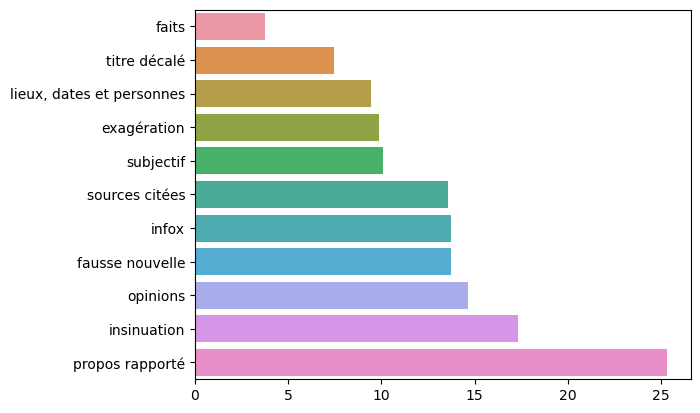

In [52]:
sns.barplot(df_std.T,orient='h')

# Prochaines étapes
---

- Nombre d'accord par valeur 0/1, à comparer avec nombre moyen
- Distance entre couples d'annotateurs
- Kappa de Fleiss
- Proposer un modele d'annotation de paragraphes

# Bricolages
---